In [1]:
import os
import cv2
import numpy as np
import math
import mediapipe as mp
from matplotlib import pyplot as plt
import glob
from util.img2bone import HandDetector
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import glob
from tqdm.auto import tqdm
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from loader.dataloader import SkeletonAndEMGData

/mnt/disk1/anaconda3/envs/anhnct/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def find_adjacency_matrix():
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()
    adj = torch.zeros((21,21))
    for connection in mp_hands.HAND_CONNECTIONS:
        adj[connection[0],connection[1]] = 1
        adj[connection[1],connection[0]] = 1
    return adj 

In [3]:
class GraphConvolution(nn.Module):
	def __init__(self, input_dim, output_dim, num_vetex, act=F.relu, dropout=0.5, bias=True):
		super(GraphConvolution, self).__init__()

		self.alpha = 1.

		self.act = act
		self.dropout = nn.Dropout(dropout)
		self.weight = nn.Parameter(torch.randn(input_dim, output_dim)).to(device)
		if bias:
			self.bias = nn.Parameter(torch.randn(output_dim)).to(device)
		else:
			self.bias = None

		for w in [self.weight]:
			nn.init.xavier_normal_(w)

	def normalize(self, m):
		rowsum = torch.sum(m, 0)
		r_inv = torch.pow(rowsum, -0.5)
		r_mat_inv = torch.diag(r_inv).float()

		m_norm = torch.mm(r_mat_inv, m)
		m_norm = torch.mm(m_norm, r_mat_inv)

		return m_norm

	def forward(self, adj, x):

		x = self.dropout(x)

		# K-ordered Chebyshev polynomial
		adj_norm = self.normalize(adj)
		sqr_norm = self.normalize(torch.mm(adj,adj))
		m_norm = (self.alpha*adj_norm + (1.-self.alpha)*sqr_norm).to(device)

		x_tmp = torch.einsum('abcd,de->abce', x, self.weight)
		x_out = torch.einsum('ij,abid->abjd', m_norm, x_tmp)
		if self.bias is not None:
			x_out += self.bias
		x_out = self.act(x_out)
  
		
		return x_out
		
		

class StandConvolution(nn.Module):
	def __init__(self, dims, num_classes, dropout):
		super(StandConvolution, self).__init__()

		self.dropout = nn.Dropout(dropout)
		self.conv = nn.Sequential(
								   nn.Conv2d(dims[0], dims[1], kernel_size=5, stride=2),
								   nn.InstanceNorm2d(dims[1]),
								   nn.ReLU(inplace=True),
								   #nn.AvgPool2d(3, stride=2),
								   nn.Conv2d(dims[1], dims[2], kernel_size=5, stride=2),
								   nn.InstanceNorm2d(dims[2]),
								   nn.ReLU(inplace=True),
								   #nn.AvgPool2d(3, stride=2),
								   nn.Conv2d(dims[2], dims[3], kernel_size=5, stride=2),
								   nn.InstanceNorm2d(dims[3]),
								   nn.ReLU(inplace=True),
								   #nn.AvgPool2d(3, stride=2)
								   ).to(device)

		self.fc = nn.Linear(dims[3]*5*5, num_classes).to(device)

	def forward(self, x):
		x = self.dropout(x.permute(0,3,1,2))# (1,9,62,63)
		x_tmp = self.conv(x)
		
		# x_out = self.fc(x_tmp.view(x.size(0), -1))

		# return x_out
		return x_tmp.view(x.size(0), -1)
class GGCN(nn.Module):
	def __init__(self, adj, num_classes, gc_dims, sc_dims, dropout=0.5):
		super(GGCN, self).__init__()

		
		adj = adj + torch.eye(adj.size(0)).to(adj).detach()
		ident = torch.eye(adj.size(0)).to(adj)
		zeros = torch.zeros(adj.size(0), adj.size(1)).to(adj)
		self.adj = torch.cat([torch.cat([adj, ident, zeros], 1),
							  torch.cat([ident, adj, ident], 1),
							  torch.cat([zeros, ident, adj], 1)], 0).float()
	
		self.gcl = GraphConvolution(gc_dims[0], gc_dims[1], 21, dropout=dropout)
		self.conv= StandConvolution(sc_dims, num_classes, dropout=dropout)

	def forward(self, x):
		# x: 
		x = torch.cat([x[:,:-2],x[:,1:-1],x[:,2:]],dim = 2)
		multi_conv = self.gcl(self.adj, x) 
		logit = self.conv(multi_conv) 
		return logit

In [4]:
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, emg_size, patch_height, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        emg_height, emg_width = pair(emg_size)


        num_patches = int(emg_height//patch_height)
        patch_dim = int(emg_width * patch_height )
        
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b (h p1) c -> b h (p1 c)', h = num_patches, c = emg_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.to_patch_embedding(x)
        
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        # return self.mlp_head(x)
        return x

In [5]:
class MultiModel(nn.Module):
    def __init__(self, adj, num_classes, gc_dims, sc_dims, 
                 emg_size, patch_height, dim, depth, heads, mlp_dim, pool = 'cls',
                 dim_head = 64, vit_dropout = 0., emb_dropout = 0.,GCN_dropout=0.2
                 ):
        super(MultiModel, self).__init__()
        self.gcn = GGCN(find_adjacency_matrix(),num_classes,gc_dims,sc_dims,GCN_dropout).float()
        self.vit = ViT(emg_size=emg_size,patch_height=patch_height,num_classes=num_classes,dim = dim,depth=depth,mlp_dim=mlp_dim,heads=heads,
                       dim_head=dim_head,dropout = vit_dropout,emb_dropout = emb_dropout).double()
        self.fc = nn.Linear(2944, num_classes).double()
    def forward(self, video,emg):
        x1 = self.gcn(video).double()
        x2 = self.vit(emg)
        x = torch.cat([x1,x2],dim = -1)
        print(x.shape)
        return self.fc(x)
        

In [6]:

def train(train_loader,model,criterion,optimizer,device):
    running_loss = 0
    model.train()
   
    for videos,labels,emgs in tqdm(train_loader):
        
        videos = videos.to(device)
        labels = labels.to(device)
        emgs = emgs.to(device).double()
        
        # forward
        outputs = model(videos,emgs)
        loss = criterion(outputs,labels)
        running_loss += loss.item()
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    
    epoch_loss = running_loss / (len(train_loader))
    return model,epoch_loss,optimizer

def validate(valid_loader,model,criterion,device):
    model.eval()
    running_loss = 0
   
    
    for videos,labels,emgs in tqdm(valid_loader):
       
        videos = videos.to(device)
        labels = labels.to(device)
        emgs = emgs.to(device).double()
        
        # forward
        
        outputs = model(videos,emgs)
        loss = criterion(outputs,labels)
        running_loss += loss.item()

    epoch_loss = running_loss / (len(valid_loader))
    return model,epoch_loss

def get_accuracy(model,data_loader,device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for videos,labels,emgs in data_loader:
            videos = videos.to(device)
            labels = labels.to(device)
            emgs = emgs.to(device).double()
            
            # forward
            outputs = model(videos,emgs)
            predicted = torch.argmax(torch.softmax(outputs,1),1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
    return correct*100/total

def plot_losses(train_losses,valid_losses):
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_losses, color="blue", label="train_loss")
    ax1.plot(valid_losses, color="red", label="valid_loss")
    ax1.set(title="Loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax1.legend()
    
def plot_accuracy(train_acc,valid_acc):
    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_acc, color="blue", label="train_acc")
    ax1.plot(valid_acc, color="red", label="val_acc")
    ax1.set(title="Accuracy over epochs",
            xlabel="Epoch",
            ylabel="Accuracy")
    ax1.legend()

In [7]:
train_set = SkeletonAndEMGData("data/108_new/train.pkl")
val_set = SkeletonAndEMGData("data/108_new/val.pkl")
test_set = SkeletonAndEMGData("data/108_new/test.pkl")

train_loader = DataLoader(train_set,batch_size = 128,drop_last = False)
valid_loader = DataLoader(val_set,batch_size = 128,drop_last = False)
test_loader = DataLoader(test_set,batch_size = 128,drop_last = False)
    

tensor([33, 10, 10, 37])
tensor([33, 10, 37])
tensor([33, 10])


In [8]:
model = MultiModel(find_adjacency_matrix(),41,[3,9],[9, 16, 32, 64],
                   emg_size=(132300,8),patch_height=int(44100*0.2),
                   dim = 1024,depth=3,mlp_dim=2048,heads=8
                   ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 15
train_losses = []
valid_losses = []
train_accuracy = []
val_accuracy = []
for epoch in range(epochs):
    # training
    model,train_loss,optimizer = train(train_loader,model,criterion,optimizer,device)
    
    # validation
    with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, device)
    train_acc = get_accuracy(model,train_loader,device)
    val_acc = get_accuracy(model,valid_loader,device)
    print("Epoch {} --- Train loss = {} --- Valid loss = {} -- Train set accuracy = {} % Valid set Accuracy = {} %".format
          (epoch+1,train_loss,valid_loss,train_acc,val_acc))
    # save loss value
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    #save accuracy
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([4, 2944])


100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


torch.Size([3, 2944])
torch.Size([4, 2944])
torch.Size([3, 2944])
Epoch 1 --- Train loss = 3.6026234289732315 --- Valid loss = 1.958267025951524 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]

torch.Size([4, 2944])



100%|██████████| 1/1 [00:00<00:00, 24.60it/s]


torch.Size([3, 2944])
torch.Size([4, 2944])
torch.Size([3, 2944])
Epoch 2 --- Train loss = 1.3225289302248802 --- Valid loss = 1.7204879661502401 -- Train set accuracy = 50.0 % Valid set Accuracy = 66.66666666666667 %


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


torch.Size([4, 2944])


100%|██████████| 1/1 [00:00<00:00, 23.56it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 3 --- Train loss = 2.430801912289857 --- Valid loss = 0.2947281647077583 -- Train set accuracy = 50.0 % Valid set Accuracy = 66.66666666666667 %


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]

torch.Size([4, 2944])



100%|██████████| 1/1 [00:00<00:00, 23.05it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])
torch.Size([3, 2944])


Epoch 4 --- Train loss = 0.5157760964071995 --- Valid loss = 0.04721729486318799 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


torch.Size([4, 2944])


100%|██████████| 1/1 [00:00<00:00, 21.99it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 5 --- Train loss = 0.024008337453390895 --- Valid loss = 0.11334478769082669 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]

torch.Size([4, 2944])



100%|██████████| 1/1 [00:00<00:00, 23.62it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 6 --- Train loss = 0.04406134113013788 --- Valid loss = 0.11920865600709123 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


torch.Size([4, 2944])


100%|██████████| 1/1 [00:00<00:00, 23.73it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])
torch.Size([3, 2944])


Epoch 7 --- Train loss = 0.03926420168033675 --- Valid loss = 0.06139955916452688 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


torch.Size([4, 2944])


100%|██████████| 1/1 [00:00<00:00, 19.75it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 8 --- Train loss = 0.02234926939137077 --- Valid loss = 0.014674145057066447 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([4, 2944])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([3, 2944])


100%|██████████| 1/1 [00:00<00:00, 17.29it/s]

torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 9 --- Train loss = 0.00489285830476895 --- Valid loss = 0.0033407466451638255 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([4, 2944])


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 10 --- Train loss = 0.00122952116873218 --- Valid loss = 0.0013493090466087654 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]

torch.Size([4, 2944])



100%|██████████| 1/1 [00:00<00:00, 23.55it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 11 --- Train loss = 0.0006674797943961182 --- Valid loss = 0.0010872953946354212 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([4, 2944])


100%|██████████| 1/1 [00:00<00:00, 23.13it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 12 --- Train loss = 0.000887956244544908 --- Valid loss = 0.0013116753616869206 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]

torch.Size([4, 2944])



100%|██████████| 1/1 [00:00<00:00, 23.51it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])


torch.Size([3, 2944])
Epoch 13 --- Train loss = 0.0011341232663699945 --- Valid loss = 0.001779616268823212 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([4, 2944])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([3, 2944])


100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


torch.Size([4, 2944])
torch.Size([3, 2944])
Epoch 14 --- Train loss = 0.0013749096229111306 --- Valid loss = 0.0022768948459767186 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([4, 2944])


100%|██████████| 1/1 [00:00<00:00, 17.01it/s]

torch.Size([3, 2944])
torch.Size([4, 2944])
torch.Size([3, 2944])
Epoch 15 --- Train loss = 0.0012387379095335604 --- Valid loss = 0.0026892184261585153 -- Train set accuracy = 100.0 % Valid set Accuracy = 100.0 %


(None, None)

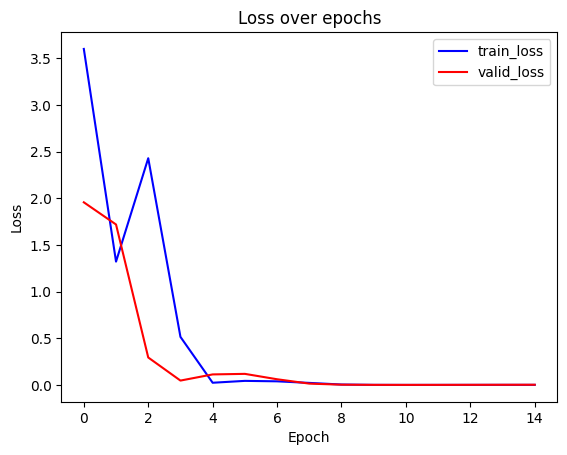

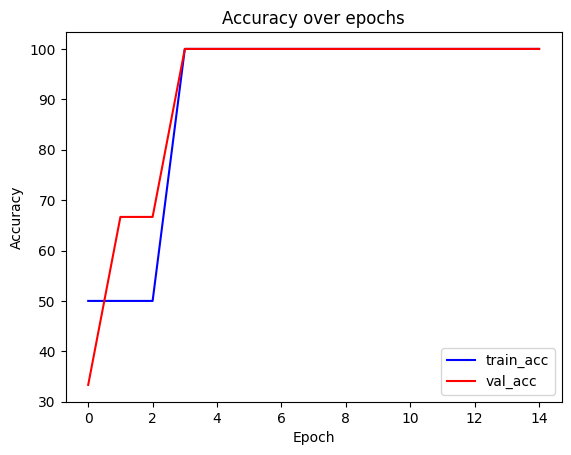

In [9]:
plot_losses(train_losses,valid_losses),plot_accuracy(train_accuracy,val_accuracy)